### Imports

In [ ]:
import requests, re, time
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import warnings
import PIL


### Download and cleanup the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"asfesaefafes","key":"d2fce6eb0eaa460f6893573d61755e34"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-05-08 09:30:51           5013  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2872  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            320  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            704  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [ ]:
! kaggle datasets download -d sebastiaanjohn/sneakers

100% 8.46G/8.47G [03:16<00:00, 30.2MB/s]
100% 8.47G/8.47G [03:16<00:00, 46.2MB/s]


In [ ]:
! unzip sneakers.zip -d /content/Kaggle_sneakers_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/adidas Ultra Boost 4.0 Orca/14.jpg  
  inflating: /content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/adidas Ultra Boost 4.0 Orca/15.jpg  
  inflating: /content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/adidas Ultra Boost 4.0 Orca/16.jpg  
  inflating: /content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/adidas Ultra Boost 4.0 Orca/17.jpg  
  inflating: /content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/adidas Ultra Boost 4.0 Orca/18.jpg  
  inflating: /content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/adidas Ultra Boost 4.0 Orca/19.jpg  
  inflating: /content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/adidas Ultra Boost 4.0 Orca/2.jpg  
  inflating: /content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/adidas Ultra Boost 4.0 Orca/20.jpg  
  inflating: /content/Kaggle_sneakers_dataset/sneaker_

In [ ]:
rootdir = '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train'
warnings.filterwarnings("error")
#if image won't open delete it
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
      path = os.path.join(subdir, file)
      try:
        im = Image.open(path)
        im.close()
      except:
        os.remove(path)
warnings.resetwarnings()

### Creating and initializing the full dataset

In [ ]:
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
horiz = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomHorizontalFlip(1)])
rotate = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomRotation(180)])
perspective = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomPerspective(distortion_scale=0.5, p=1.0, fill=0)])

normal_dataset = datasets.ImageFolder('/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train', transform=xform)
horiz_flip_dataset = datasets.ImageFolder('/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train', transform=horiz)
rotate_dataset = datasets.ImageFolder('/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train', transform=rotate)
perspective_dataset = datasets.ImageFolder('/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train', transform=perspective)
dataset_full = normal_dataset + perspective_dataset + rotate_dataset + horiz_flip_dataset

In [ ]:
rng = torch.Generator().manual_seed(1549)

In [ ]:
#real dataset
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train

dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 8, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 8, shuffle=True)

categories = 0
path = '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train'

for folders in os.listdir(path):
    categories += 1

print(categories)
print(len(dataset_full))
print(len(dataset_train))
print(len(dataset_test))
#categories should = 899 

899
211080
168864
42216


### Create a small dataset with 12 similar shoes for testing

In [ ]:
! mkdir small_test

In [ ]:
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 OG Chicago (1985)' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro Black Metallic Gold (2013)' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro Black Royal Blue (2001)' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro Bred ""Banned"" (2016)"' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro High ""Not for Resale"" Varsity Maize"' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro High Aleali May Court Lux (W)' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro High Bio Beige Anthracite Mystic Green (W)' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro High Black Crimson Tint' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro High Black Gym Red' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro High Blue Moon' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro High Bred Toe' '/content/small_test'
!cp -R '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train/Jordan 1 Retro High Camo 3M Bred' '/content/small_test'

In [ ]:
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
# horiz = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomHorizontalFlip(1)])
rotate = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomRotation(180)])
perspective = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomPerspective()])

normal_dataset = datasets.ImageFolder('/content/small_test', transform=xform)
# horiz_flip_dataset = datasets.ImageFolder('/content/small_test', transform=horiz)
rotate_dataset = datasets.ImageFolder('/content/small_test', transform=rotate)
perspective_dataset = datasets.ImageFolder('/content/small_test', transform=perspective)

small_dataset = normal_dataset + rotate_dataset + perspective_dataset + horiz_flip_dataset

In [ ]:
rng = torch.Generator().manual_seed(1549)

In [ ]:
# small dataset
n_small = len(small_dataset)
n_train_small = int(0.8 * n_small)
n_test_small = n_small - n_train_small

dataset_train, dataset_test = torch.utils.data.random_split(small_dataset, [n_train_small, n_test_small], rng)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 32, shuffle=True)

categories = 0
path = '/content/small_test'

for folders in os.listdir(path):
    categories += 1

print(categories)
print(len(small_dataset))
print(len(dataset_train))
print(len(dataset_test))
# categories should = 12

12
2031
1624
407


#### Checking photos in the full and small datasets

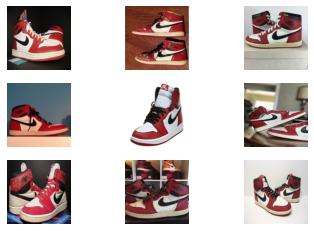

In [ ]:
for x in range(9):
  plt.subplot(3,3,x+1)
  plt.axis('off')
  plt.imshow(small_dataset[x][0].permute(1,2,0))

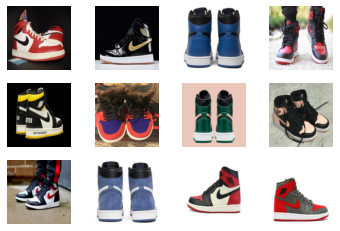

In [ ]:
for x in range(12):
  for y in range(len(small_dataset)):
    if small_dataset[y][1] == x:
      plt.subplot(3,4,x+1)
      plt.axis('off')    
      plt.imshow(small_dataset[y][0].permute(1,2,0))
      break

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


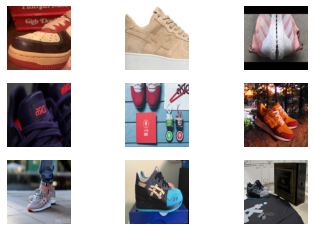

In [ ]:
for x in range(9):
  for y in range(len(dataset_full)):
    if dataset_full[y][1] == x:
      plt.subplot(3,3,x+1)
      plt.axis('off')    
      plt.imshow(dataset_full[y][0].permute(1,2,0))
      break

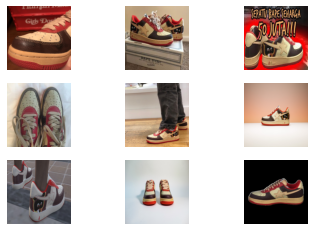

In [ ]:
for x in range(9):
  if dataset_full[x][1] == 0:
    plt.subplot(3,3,x+1)
    plt.axis('off')
    plt.imshow(dataset_full[x][0].permute(1,2,0))
    # print(dataset_full[x][1])

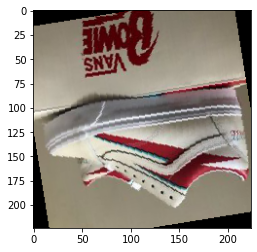

In [ ]:
 plt.imshow(dataset_full[200002][0].permute(1,2,0))

### Preparing the model

If you are loading a saved model go to the load the model section

In [ ]:
# Do not use if you are loading a saved model
model = models.resnet18(pretrained=True)

layer1 = torch.nn.Linear(model.fc.in_features, 500)
layer2 = torch.nn.Linear(500, 500)
layer3 = torch.nn.Linear(500, categories) 
torch.nn.init.xavier_uniform_(layer1.weight)
torch.nn.init.xavier_uniform_(layer2.weight)
torch.nn.init.xavier_uniform_(layer3.weight)

model.fc = nn.Sequential(
          layer1,
          nn.ReLU(),
          layer2,
          nn.ReLU(),
          layer3
        )

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Load entire model
ENTIRE_MODEL_PATH = "drive/MyDrive/entire_model_epoch14.pt"
model = torch.load(ENTIRE_MODEL_PATH)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Load model with state dictionary 
model = models.resnet18(pretrained=True)
layer1 = torch.nn.Linear(model.fc.in_features, 500)
layer2 = torch.nn.Linear(500, 500)
layer3 = torch.nn.Linear(500, categories) 
torch.nn.init.xavier_uniform_(layer1.weight)
torch.nn.init.xavier_uniform_(layer2.weight)
torch.nn.init.xavier_uniform_(layer3.weight)

model.fc = nn.Sequential(
          layer1,
          nn.ReLU(),
          layer2,
          nn.ReLU(),
          layer3
        )

STATE_PATH = "state_dict_epoch7.pt"
model.load_state_dict(torch.load(STATE_PATH))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
device = torch.device('cuda:0')
model = model.to(device)

In [ ]:
print(categories, len(dataset_full), len(dataset_train), len(dataset_test))

899 211080 168864 42216


In [ ]:
criterion = nn.CrossEntropyLoss()

def run_test(model):
    nsamples_test = len(dataset_test)
    loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device)
            outs = model(samples)
            loss += criterion(outs, labels)
            _, preds = torch.max(outs.detach(), 1)
            correct_mask = preds == labels
            correct += correct_mask.sum(0).item()
    return loss / nsamples_test, correct / nsamples_test

In [ ]:
def run_train(model, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        for samples, labels in loader_train:
            samples = samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()
            outs = model(samples)
            _, preds = torch.max(outs.detach(), 1)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            correct_sofar += torch.sum(preds == labels.detach())
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

In [ ]:
def run_all(model, optimizer, scheduler, n_epochs):
    for epoch in range(n_epochs):
        loss_train, acc_train = run_train(model, optimizer, scheduler)
        loss_test, acc_test = run_test(model)
        print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")

In [ ]:
run_test(model)

(tensor(0.0897, device='cuda:0'), 0.08487084870848709)

In [ ]:
run_all(model, optimizer, scheduler, 1)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch 0: train loss 0.1300 acc 0.9570, test loss 0.0140 acc 0.9620


In [ ]:
model = model.to('cpu')

In [ ]:
model.eval()
ENTIRE_MODEL_PATH = "test3.pt"

torch.save(model, ENTIRE_MODEL_PATH)
from google.colab import files
files.download(ENTIRE_MODEL_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Save the model

In [ ]:
# Save entire model
model.eval()
ENTIRE_MODEL_PATH = "entire_model_epoch15.pt"

torch.save(model, ENTIRE_MODEL_PATH)
from google.colab import files
files.download(ENTIRE_MODEL_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save model with state dictionary
model.eval()
STATE_PATH = "state_dict_epoch15.pt"

torch.save(model.state_dict(), STATE_PATH)
from google.colab import files
files.download(STATE_PATH) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Test model with singular image

In [ ]:
test_img = PIL.Image.open('drive/MyDrive/shoe12.jpg')
plt.imshow(test_img)
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
test_tens = xform(test_img)
test_tens = test_tens.unsqueeze(0)
#test_tens = test_tens.cuda()
with torch.no_grad():
  model_out = model(test_tens)
  _, shoe_class_tensor = torch.max(model_out, 1)
  shoe_class = shoe_class_tensor.cpu().data.numpy()
print(shoe_class)

NameError: ignored

In [ ]:
dir = '/content/Kaggle_sneakers_dataset/sneaker_dataset/images/train'
classes = os.listdir(dir)
classes.sort()
print(classes[int(shoe_class)])

### Save model for pytorch mobile

In [ ]:
model = model.to('cpu')
mobile = torch.quantization.convert(model)
scripted = torch.jit.script(mobile)
torch.jit.save(scripted, "train_jit_model.pt")

### Training and testing log for small dataset


In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=True)

In [ ]:
model = models.resnet18(pretrained=True)

layer1 = torch.nn.Linear(model.fc.in_features, 500)
layer2 = torch.nn.Linear(500, 500)
layer3 = torch.nn.Linear(500, categories) 
torch.nn.init.xavier_uniform_(layer1.weight)
torch.nn.init.xavier_uniform_(layer2.weight)
torch.nn.init.xavier_uniform_(layer3.weight)

model.fc = nn.Sequential(
          layer1,
          nn.ReLU(),
          layer2,
          nn.ReLU(),
          layer3
        )

In [ ]:
device = torch.device('cuda:0')
model = model.to(device)

In [ ]:
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.95)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

| test # | optimizer | scheduler | learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch |
|--------|-----------|-----------|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| 1      | SGD       | StepLR    | 0.001         | 0.9      | 5         | 0.1   | 32        | 0.0209    | 0.8280   | 8        |
| 2      | SGD       | StepLR    | 0.0001        | 0.9      | 5         | 0.1   | 4        | 0.2631   | 0.6830   | 7      |
| 3      | SGD       | StepLR    | 0.001         | 0.9      | 5         | 0.1   | 4        | 0.1063   | 0.8771   | 9      |
| 4      | SGD       | StepLR    | 0.001         | 0.9      | 3         | 0.1   | 4        | 0.1158   | 0.8354   | 6      |
| 5      | SGD       | StepLR    | 0.001         | 0.5      | 5         | 0.1   | 4        | 0.1521   | 0.8157   | 9      |
| 6      | SGD       | StepLR    | 0.001         | 0.95     | 5         | 0.1   | 8        | 0.0368   | 0.9140   | 9      |
| 7      | SGD       | StepLR    | 0.001         | 0.95     | 5         | 0.1   | 16       | 0.0206   | 0.8943   | 7      |
| 8      | SGD       | StepLR    | 0.001         | 0.95     | 5         | 0.1   | 4       | 0.0909   | 0.8722   | 7      |


Test 1

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 2.2368 acc 0.2635, test loss 0.0580 acc 0.4693
epoch 1: train loss 1.5917 acc 0.5683, test loss 0.0437 acc 0.6192
epoch 2: train loss 1.1870 acc 0.6663, test loss 0.0332 acc 0.6757
epoch 3: train loss 0.9196 acc 0.7414, test loss 0.0260 acc 0.7961
epoch 4: train loss 0.7362 acc 0.8005, test loss 0.0226 acc 0.8034
epoch 5: train loss 0.6470 acc 0.8362, test loss 0.0214 acc 0.8182
epoch 6: train loss 0.6223 acc 0.8411, test loss 0.0211 acc 0.8256
epoch 7: train loss 0.6101 acc 0.8442, test loss 0.0208 acc 0.8182
epoch 8: train loss 0.6005 acc 0.8430, test loss 0.0209 acc 0.8280
epoch 9: train loss 0.6053 acc 0.8344, test loss 0.0208 acc 0.8256


Test 2

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 2.3119 acc 0.2180, test loss 0.5181 acc 0.3538
epoch 1: train loss 2.0116 acc 0.3922, test loss 0.4368 acc 0.4988
epoch 2: train loss 1.7529 acc 0.4791, test loss 0.3661 acc 0.5848
epoch 3: train loss 1.5581 acc 0.5283, test loss 0.3132 acc 0.6143
epoch 4: train loss 1.3966 acc 0.5911, test loss 0.2644 acc 0.6437
epoch 5: train loss 1.3177 acc 0.6078, test loss 0.2648 acc 0.6658
epoch 6: train loss 1.2623 acc 0.6145, test loss 0.2666 acc 0.6609
epoch 7: train loss 1.2654 acc 0.6281, test loss 0.2631 acc 0.6830
epoch 8: train loss 1.2246 acc 0.6392, test loss 0.2600 acc 0.6683
epoch 9: train loss 1.2182 acc 0.6244, test loss 0.2464 acc 0.6830


Test 3

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 1.8145 acc 0.4144, test loss 0.2315 acc 0.6855
epoch 1: train loss 1.2421 acc 0.5893, test loss 0.1774 acc 0.7592
epoch 2: train loss 1.0424 acc 0.6502, test loss 0.1384 acc 0.8182
epoch 3: train loss 0.8881 acc 0.6964, test loss 0.1415 acc 0.8157
epoch 4: train loss 0.8315 acc 0.7100, test loss 0.1321 acc 0.8231
epoch 5: train loss 0.6744 acc 0.7808, test loss 0.1107 acc 0.8477
epoch 6: train loss 0.6585 acc 0.7820, test loss 0.1063 acc 0.8550
epoch 7: train loss 0.6603 acc 0.7839, test loss 0.1099 acc 0.8698
epoch 8: train loss 0.6392 acc 0.7950, test loss 0.1042 acc 0.8403
epoch 9: train loss 0.5977 acc 0.7974, test loss 0.1063 acc 0.8771


Test 4

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 1.9016 acc 0.3633, test loss 0.2679 acc 0.6339
epoch 1: train loss 1.2461 acc 0.5764, test loss 0.1715 acc 0.7690
epoch 2: train loss 1.0200 acc 0.6515, test loss 0.1415 acc 0.7912
epoch 3: train loss 0.7389 acc 0.7438, test loss 0.1262 acc 0.8157
epoch 4: train loss 0.7025 acc 0.7672, test loss 0.1335 acc 0.8157
epoch 5: train loss 0.7039 acc 0.7654, test loss 0.1259 acc 0.8034
epoch 6: train loss 0.6814 acc 0.7789, test loss 0.1158 acc 0.8354
epoch 7: train loss 0.6947 acc 0.7703, test loss 0.1308 acc 0.8256
epoch 8: train loss 0.7103 acc 0.7654, test loss 0.1302 acc 0.8084
epoch 9: train loss 0.6743 acc 0.7833, test loss 0.1257 acc 0.8206


Test 5

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 2.2483 acc 0.2605, test loss 0.4664 acc 0.4226
epoch 1: train loss 1.7728 acc 0.4569, test loss 0.3160 acc 0.6609
epoch 2: train loss 1.4285 acc 0.5523, test loss 0.2482 acc 0.7076
epoch 3: train loss 1.1973 acc 0.6182, test loss 0.2046 acc 0.7445
epoch 4: train loss 1.0729 acc 0.6490, test loss 0.1765 acc 0.7740
epoch 5: train loss 0.9927 acc 0.6903, test loss 0.1827 acc 0.7641
epoch 6: train loss 0.9849 acc 0.6964, test loss 0.1821 acc 0.7568
epoch 7: train loss 0.9306 acc 0.7124, test loss 0.1666 acc 0.7936
epoch 8: train loss 0.9325 acc 0.7254, test loss 0.1584 acc 0.7912
epoch 9: train loss 0.9202 acc 0.7118, test loss 0.1521 acc 0.8157


Test 6

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 1.7421 acc 0.4273, test loss 0.1204 acc 0.6781
epoch 1: train loss 0.9843 acc 0.6724, test loss 0.0870 acc 0.7396
epoch 2: train loss 0.7557 acc 0.7365, test loss 0.0709 acc 0.7961
epoch 3: train loss 0.7040 acc 0.7543, test loss 0.0913 acc 0.7052
epoch 4: train loss 0.5839 acc 0.7913, test loss 0.0590 acc 0.8378
epoch 5: train loss 0.4117 acc 0.8719, test loss 0.0465 acc 0.8870
epoch 6: train loss 0.4180 acc 0.8688, test loss 0.0442 acc 0.8747
epoch 7: train loss 0.3842 acc 0.8787, test loss 0.0500 acc 0.8550
epoch 8: train loss 0.3747 acc 0.8799, test loss 0.0477 acc 0.8624
epoch 9: train loss 0.4064 acc 0.8658, test loss 0.0368 acc 0.9140


Test 7

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 1.8854 acc 0.3781, test loss 0.0763 acc 0.6388
epoch 1: train loss 0.9406 acc 0.7038, test loss 0.0420 acc 0.8157
epoch 2: train loss 0.6375 acc 0.7894, test loss 0.0385 acc 0.8084
epoch 3: train loss 0.5380 acc 0.8239, test loss 0.0375 acc 0.8108
epoch 4: train loss 0.5249 acc 0.8202, test loss 0.0235 acc 0.8845
epoch 5: train loss 0.3423 acc 0.8990, test loss 0.0228 acc 0.8796
epoch 6: train loss 0.3274 acc 0.8996, test loss 0.0223 acc 0.8919
epoch 7: train loss 0.3290 acc 0.8990, test loss 0.0206 acc 0.8943
epoch 8: train loss 0.3305 acc 0.9015, test loss 0.0221 acc 0.8870
epoch 9: train loss 0.3343 acc 0.9027, test loss 0.0230 acc 0.8845


Test 8

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 1.8797 acc 0.3627, test loss 0.2459 acc 0.6609
epoch 1: train loss 1.2825 acc 0.5696, test loss 0.2015 acc 0.6978
epoch 2: train loss 1.1275 acc 0.6004, test loss 0.1449 acc 0.7961
epoch 3: train loss 1.0233 acc 0.6533, test loss 0.1519 acc 0.7936
epoch 4: train loss 0.8779 acc 0.7001, test loss 0.1289 acc 0.8378
epoch 5: train loss 0.7278 acc 0.7543, test loss 0.1159 acc 0.8428
epoch 6: train loss 0.6313 acc 0.7900, test loss 0.1060 acc 0.8501
epoch 7: train loss 0.6792 acc 0.7808, test loss 0.0909 acc 0.8722
epoch 8: train loss 0.6112 acc 0.7913, test loss 0.1128 acc 0.8378
epoch 9: train loss 0.6156 acc 0.7876, test loss 0.1064 acc 0.8501


#### Test run with 6 similar shoes with data augmentation using Adam optimizer and StepLR scheduler.
epoch 0: train loss 0.7798 acc 0.7046, test loss 0.0623 acc 0.9212 \\
epoch 1: train loss 0.5777 acc 0.7948, test loss 0.0629 acc 0.9261 \\
epoch 2: train loss 0.5962 acc 0.7911, test loss 0.0448 acc 0.9360 \\
epoch 3: train loss 0.5110 acc 0.8294, test loss 0.0351 acc 0.9507 \\
epoch 4: train loss 0.3494 acc 0.8776, test loss 0.0244 acc 0.9655 \\
epoch 5: train loss 0.3552 acc 0.8813, test loss 0.0204 acc 0.9507 \\
epoch 6: train loss 0.2932 acc 0.9036, test loss 0.0247 acc 0.9655 \\
epoch 7: train loss 0.2899 acc 0.9011, test loss 0.0214 acc 0.9655 \\
epoch 8: train loss 0.2879 acc 0.8888, test loss 0.0153 acc 0.9754 \\
epoch 9: train loss 0.3038 acc 0.8900, test loss 0.0188 acc 0.9704 \\



### Training and testing log for full dataset

####test run with no data augmentation and default optimizer/scheduler 
epoch 0: train loss 2.5095 acc 0.4107, test loss 0.3937 acc 0.6182 \\
epoch 1: train loss 1.7194 acc 0.5706, test loss 0.3227 acc 0.6866

#### small dataset With adam 5000 to 2000 to 
epoch 0: train loss 1.8016 acc 0.4215, test loss 0.1890 acc 0.7740 \\
epoch 1: train loss 0.8763 acc 0.7008, test loss 0.1262 acc 0.8446 \\
epoch 2: train loss 0.7749 acc 0.7355, test loss 0.0836 acc 0.8955 \\
epoch 3: train loss 0.6171 acc 0.7992, test loss 0.0533 acc 0.9492 \\
epoch 4: train loss 0.6289 acc 0.8027, test loss 0.0597 acc 0.9350 \\
epoch 5: train loss 0.4218 acc 0.8678, test loss 0.0481 acc 0.9350 \\
epoch 6: train loss 0.3780 acc 0.8769, test loss 0.0435 acc 0.9576 \\
epoch 7: train loss 0.3153 acc 0.9066, test loss 0.0398 acc 0.9605 \\
epoch 8: train loss 0.3288 acc 0.8883, test loss 0.0301 acc 0.9689 \\
epoch 9: train loss 0.3593 acc 0.8784, test loss 0.0505 acc 0.9492 \\

no augment full dataset, batch size = 32 \\
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) \\
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) \\
500 500 \\
epoch 0: train loss 6.1859 acc 0.0454, test loss 0.1447 acc 0.1798 \\
epoch 1: train loss 3.1199 acc 0.3759, test loss 0.0628 acc 0.5466 \\
epoch 2: train loss 1.4818 acc 0.6559, test loss 0.0385 acc 0.7037 \\
epoch 3: train loss 0.8823 acc 0.7832, test loss 0.0305 acc 0.7639 \\
epoch 4: train loss 0.5797 acc 0.8543, test loss 0.0270 acc 0.7846 \\
epoch 5: train loss 0.2877 acc 0.9368, test loss 0.0212 acc 0.8368 \\
epoch 6: train loss 0.2339 acc 0.9511, test loss 0.0211 acc 0.8356 \\
epoch 7: train loss 0.2154 acc 0.9553, test loss 0.0211 acc 0.8354 \\
epoch 8: train loss 0.1980 acc 0.9596, test loss 0.0209 acc 0.8388 \\
epoch 9: train loss 0.1835 acc 0.9625, test loss 0.0209 acc 0.8399 \\

all augment full dataset, batch size = 32 \\
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) \\
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) \\
500 500 \\
epoch 0: train loss 3.2306 acc 0.4026, test loss 0.0307 acc 0.7570 \\
epoch 1: train loss 0.7468 acc 0.8090, test loss 0.0166 acc 0.8623 \\
about 4 hours

optimizer = optim.SGD(**model.fc.parameters()**, lr=0.001, momentum=0.9) \\
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) \\
9h32m runtime \\
epoch 0: train loss 5.3263 acc 0.1097, test loss 0.1007 acc 0.3293 \\
epoch 1: train loss 2.6442 acc 0.4218, test loss 0.0648 acc 0.5302 \\
epoch 2: train loss 1.9691 acc 0.5466, test loss 0.0546 acc 0.5907 \\
epoch 3: train loss 1.6796 acc 0.6043, test loss 0.0484 acc 0.6309 \\

only random perspective augment, batch size = 8 \\
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95) \\
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) \\
layer features = 500 500 899 \\
runtime 8h \\
epoch 0: train loss 3.5650 acc 0.2820, test loss 0.2172 acc 0.5704 \\
epoch 1: train loss 1.5589 acc 0.6102, test loss 0.1421 acc 0.7160 \\
epoch 2: train loss 1.0881 acc 0.7141, test loss 0.1166 acc 0.7643 \\
epoch 3: train loss 0.8519 acc 0.7697, test loss 0.0977 acc 0.7974 \\
epoch 4: train loss 0.6880 acc 0.8073, test loss 0.0922 acc 0.8130 \\
epoch 5: train loss 0.3089 acc 0.9089, test loss 0.0512 acc 0.8920 \\
epoch 6: train loss 0.2312 acc 0.9294, test loss 0.0486 acc 0.9010 \\
epoch 7: train loss 0.2028 acc 0.9375, test loss 0.0464 acc 0.9046 \\
epoch 8: train loss 0.1812 acc 0.9431, test loss 0.0467 acc 0.9052 \\

real one \\
epoch 0: train loss 2.7850 acc 0.3990, test loss 0.1537 acc 0.6899 \\
epoch 1: train loss 1.2334 acc 0.6812, test loss 0.1003 acc 0.7901 \\
epoch 2: train loss 0.9083 acc 0.7555, test loss 0.1001 acc 0.7907 \\
epoch 3: train loss 0.9100 acc 0.7554, test loss 0.1014 acc 0.7887 \\
epoch 4: train loss 0.8689 acc 0.7657, test loss 0.0797 acc 0.8291 \\
epoch 5: train loss 0.6693 acc 0.8129, test loss 0.0691 acc 0.8491 \\
epoch 6: train loss 0.5431 acc 0.8438, test loss 0.0587 acc 0.8691 \\
epoch 7: train loss 0.5367 acc 0.8452, test loss 0.0508 acc 0.8812 \\
epoch 8: train loss 0.4554 acc 0.8654, test loss 0.0433 acc 0.8968 \\
epoch 9: train loss 0.3944 acc 0.8827, test loss 0.0442 acc 0.8982 \\
epoch 10: train loss 0.2230 acc 0.9298, test loss 0.0284 acc 0.9299 \\
epoch 11: train loss 0.1838 acc 0.9409, test loss 0.0273 acc 0.9329 \\
epoch 12: train loss 0.1672 acc 0.9449, test loss 0.0257 acc 0.9360 \\
epoch 13: train loss 0.1570 acc 0.9486, test loss 0.0265 acc 0.9376 \\
epoch 14: train loss 0.1506 acc 0.9503, test loss 0.0145 acc 0.9616 r \\
epoch 15: train loss 0.1319 acc 0.9560, test loss 0.0146 acc 0.9620 